# Import Libraries

In [1]:
# pip install -q phonenumbers
# !pip install shap

In [2]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F
from snowflake.snowpark.types import DecimalType

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import model_registry
from snowflake.ml._internal.utils import identifier
from xgboost import XGBClassifier

# Data Science Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Misc
import json
import joblib
import cachetools

# warning suppresion
import warnings; warnings.simplefilter('ignore')

import phonenumbers

import shap

# Data preparation
## Connect to snowflake

In [3]:
# Make a Snowpark Connection

connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : MARK1971
Role                        : "ACCOUNTADMIN"
Database                    : "YALA_DB"
Schema                      : "PUBLIC"
Warehouse                   : "COMPUTE_WH"
Snowflake version           : 7.42.2
Snowpark for Python version : 1.9.0


In [4]:
# Specify the table name where we stored the diamonds dataset
# **nChange this only if you named your table something else in the data ingest notebook **
CONVERTEDONLY_LEADS_TABLE = 'CONVERTEDONLY'
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{CONVERTEDONLY_LEADS_TABLE}"

In [5]:
# First, we read in the data from a Snowflake table into a Snowpark DataFrame
leads_df = session.table(input_tbl)

## Drop features without values

In [6]:
leads_df = leads_df.drop('SALUTATION'
,'TITLE'
,'FIRSTNAME'
,'LASTNAME'
,'WEBSITE'
,'CONVERTEDCONTACTID'
,'CONVERTEDDATE'
,'CONVERTEDCONTACTID'
,'CONVERTEDORGANIZATIONID'
,'UPDATEDDATE'
,'EMPLOYEECOUNT'
,'LEADRATING'
,'FAX'
,'INDUSTRY'
,'OWNERUSERID'
,'RESPONSIBLEUSERID'
,'ADDRESSSTREET'
,'ADDRESSCITY'
,'ADDRESSSTATE'
,'ADDRESSPOSTCODE'
,'LASTACTIVITYDATE'
,'NEXTACTIVITYDATE'
,'VISIBLETO'
,'VISIBLETEAMID'
,'ORGANIZATIONNAME'
,'CREATEDUSERID'
,'IMAGEURL'
,'TAGS'
,'O_ID'
, 'CONVERTED'
, 'CONVERTEDOPPORTUNITYID')


## Fill Email with default value once empty

In [7]:
# Checking for missing values in the leads_df EMAIL dataframe column
leads_df = leads_df.na.replace('', "unknown@unknown.nl", subset='EMAIL')
# leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')
# leads_df.show()
print(leads_df.columns)

['ID', 'LEADSTATUSID', 'LEADSOURCEID', 'CREATEDDATE', 'EMAIL', 'LEADDESCRIPTION', 'MOBILE', 'PHONE', 'ADDRESSCOUNTRY', 'CUSTOMFIELDS', 'O_OPPORTUNITYSTATE']


## Create new column with Email domain only

In [8]:
# List of identified private email domains
private_domains = [
    'gmail.com', 'hotmail.com', 'orange.fr', 'wanadoo.fr', 'hotmail.fr',
    'yahoo.com', 'outlook.com', 'hotmail.co.uk', 'me.com', 'gmx.de',
    'icloud.com', 'yahoo.it', 'libero.it', 'web.de', 'kpnmail.nl',
    'yahoo.de', 'yahoo.fr', 'free.fr', 'telenet.be', 'live.fr',
    'otenet.gr', 'mac.com', 'yahoo.co.uk', 'laposte.net', 'uol.com.br',
    'casema.nl', 'aol.com', 't-online.de', 'unknown.com', 'yahoo.in',
    'gmx.fr', 'mail.com', 'mail.ru', 'live.it', 'msn.com',
    'yahoo.com.sg', 'hotmail.it', 'googlemail.com', 'hotmail.nl', 'ziggo.nl'
]

# Extracting the domain from the 'Email' column
leads_df = leads_df.withColumn(
    "Email_Domain",
    F.regexp_extract(F.col("Email"), '@([a-zA-Z0-9.-]+)$', 1)
)


## Create new column with tagging it as Business or Private

In [9]:
# Classifying the email addresses as 'Private' or 'Business'
# merged_data_prefixed['c_Email_Type'] = merged_data_prefixed['c_Email_Domain'].apply(
#     lambda x: 'Private' if x in private_domains else 'Business')

# Creating a column to classify email as 'Private' or 'Business'
leads_df = leads_df.withColumn(
    "Email_Type",
    F.when(F.col("Email_Domain").isin(private_domains), "Private").otherwise("Business")
)
leads_df = leads_df.drop('EMAIL_DOMAIN')
# leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')

## Create new column with the length of the lead description

In [10]:
# Creating a new column 'LENGTH_LEADDESCRIPTION' indicating the length of the text in 'LEADDESCRIPTION'
leads_df = leads_df.withColumn("LENGTH_LEADDESCRIPTION", F.length(F.col("LEADDESCRIPTION")))
leads_df = leads_df.drop('LEADDESCRIPTION')
# print(leads_df.columns)


## Normalize the length of the lead-description

In [11]:
# Normalize the LEN_LEADDESC_NORM column
snowml_mms = snowml.MinMaxScaler(input_cols=["LENGTH_LEADDESCRIPTION"], output_cols=["LEN_LEADDESC_NORM"])
leads_df = snowml_mms.fit(leads_df).transform(leads_df)

# Reduce the number of decimals
new_col = leads_df.col("LEN_LEADDESC_NORM").cast(DecimalType(7, 6))
leads_df = leads_df.with_column("LEN_LEADDESC_NORM", new_col)
# leads_df.show()

## Prepare phone number information

In [12]:
# Creating a new column 'PHONENUMBER' based on 'MOBILE' and 'PHONE'
leads_df = leads_df.withColumn(
    "PHONENUMBER",
    F.when(F.col("MOBILE").isNull() | (F.col("MOBILE") == ''), F.col("PHONE")).otherwise(F.col("MOBILE"))
)
# leads_df.write.mode('overwrite').save_as_table('TMP_LEADSONLY')

In [13]:
# Creating a new column 'COUNTRYCODE' based on 'PHONENUMBER'

def get_country_code(phone_number):
    # return phn.parse(phone_number, None)
    try:
        parsed_number = phonenumbers.parse(phone_number, None)
        if phonenumbers.is_valid_number(parsed_number):
            return '+' + str(parsed_number.country_code)
    except:
        pass
    return '+00'

# Assuming leads_df is your Snowflake DataFrame
leads_df_pandas = leads_df.to_pandas()

leads_df_pandas['COUNTRYCODE'] = leads_df_pandas['PHONENUMBER'].apply(
    lambda x: get_country_code(str(x)) if pd.notna(x) else '+00'
)

session.write_pandas(leads_df_pandas, "TEMP_LEADS_TABLE", auto_create_table=True)

# Read the data back into a Snowflake DataFrame
leads_df_snowflake = session.table("TEMP_LEADS_TABLE")


# Write the Snowflake DataFrame to a permanent table
# leads_df_snowflake.write.mode("overwrite").save_as_table("TMP_LEADSONLY")


## Set default value for address country

In [14]:
# Checking for missing values in the leads_df EMAIL dataframe column
leads_df_snowflake = leads_df_snowflake.na.replace('', "Netherlands", subset='ADDRESSCOUNTRY')
leads_df_snowflake = leads_df_snowflake.na.replace('-', "Netherlands", subset='ADDRESSCOUNTRY')

## Extract year, month, week, day, and hour from 'CreatedDate'

In [15]:
# Splitting 'CreatedDate' into Year, Month, Week, Day, and Hour portions with specified format

# Assuming leads_df is your Snowflake DataFrame and 'CreatedDate' is a column in this DataFrame

# Extracting year, month, week, day, and hour from 'CreatedDate'
# Convert 'CreatedDate' to a timestamp type with the specified format
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedDate', F.to_timestamp('CreatedDate', 'MM/DD/YYYY HH12:MI:SS AM'))
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedYear', F.year('CreatedDate'))
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedMonth', F.month('CreatedDate'))
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedWeek', F.weekofyear('CreatedDate'))
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedDay', F.dayofweek('CreatedDate'))  # Note: In Snowflake, Sunday=0, Saturday=6
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedHour', F.hour('CreatedDate'))

# Adjust 'CreatedDay' to make Monday=1, Sunday=7 if needed
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedDay', (F.col('CreatedDay') % 7) + 1)




In [16]:
print(leads_df_snowflake.columns)

['ID', 'LEADSTATUSID', 'LEADSOURCEID', 'EMAIL', 'MOBILE', 'PHONE', 'ADDRESSCOUNTRY', 'CUSTOMFIELDS', 'O_OPPORTUNITYSTATE', 'EMAIL_TYPE', 'LENGTH_LEADDESCRIPTION', 'LEN_LEADDESC_NORM', 'PHONENUMBER', 'COUNTRYCODE', 'CREATEDDATE', 'CREATEDYEAR', 'CREATEDMONTH', 'CREATEDWEEK', 'CREATEDHOUR', 'CREATEDDAY']


## Drop columns you do no longer need

In [17]:
leads_df_snowflake.write.mode("overwrite").save_as_table("PRE_ENGINEERING_CONVERTEDONLY")

In [18]:
leads_df_snowflake = leads_df_snowflake.drop('MOBILE', 'PHONE', 'PHONENUMBER', 'LEADSTATUSID', 'EMAIL', 'COUNTRYCODE', 'CUSTOMFIELDS', 'CREATEDYEAR', 'CREATEDDATE')
leads_df = leads_df.drop('LENGTH_LEADDESCRIPTION')
print(leads_df_snowflake.columns)


['ID', 'LEADSOURCEID', 'ADDRESSCOUNTRY', 'O_OPPORTUNITYSTATE', 'EMAIL_TYPE', 'LENGTH_LEADDESCRIPTION', 'LEN_LEADDESC_NORM', 'CREATEDMONTH', 'CREATEDWEEK', 'CREATEDHOUR', 'CREATEDDAY']


# Feature engineering AND model preparation
## One-hot encode "LEADSOURCEID", "ADDRESSCOUNTRY" and "EMAIL_TYPE

In [19]:
# Encode categoricals to numeric columns
snowml_ohe = snowml.OneHotEncoder(input_cols=["LEADSOURCEID", "ADDRESSCOUNTRY", "EMAIL_TYPE"], output_cols=['LS', 'AD', 'ET'])
# transformed_leads_df = snowml_ohe.fit(leads_df_snowflake).transform(leads_df_snowflake)
leads_df_snowflake = snowml_ohe.fit(leads_df_snowflake).transform(leads_df_snowflake)
print(leads_df_snowflake.columns)

# np.array(leads_df_snowflake.columns)

['LS_2973396', 'LS_2973397', 'LS_2973398', 'LS_2985683', 'LS_2985685', 'LS_3306719', 'LS_3306720', 'LS_3314817', 'LS_3367610', '"AD_Armenia"', '"AD_Austria"', '"AD_Bangladesh"', '"AD_Belgium"', '"AD_Bosnia And Herzegowina"', '"AD_Brazil"', '"AD_Bulgaria"', '"AD_Croatia"', '"AD_Cyprus"', '"AD_Czech Republic"', '"AD_Denmark"', '"AD_Egypt"', '"AD_Estonia"', '"AD_France"', '"AD_Gambia"', '"AD_Georgia"', '"AD_Germany"', '"AD_Greece"', '"AD_Guadeloupe"', '"AD_Hong Kong"', '"AD_Hungary"', '"AD_India"', '"AD_Indonesia"', '"AD_Iran"', '"AD_Israel"', '"AD_Italy"', '"AD_Japan"', '"AD_Jordan"', '"AD_Kuwait"', '"AD_Lebanon"', '"AD_Luxembourg"', '"AD_Macedonia"', '"AD_Malaysia"', '"AD_Maldives"', '"AD_Mauritius"', '"AD_Moldova"', '"AD_Montenegro"', '"AD_Morocco"', '"AD_Netherlands"', '"AD_Netherlands Antilles"', '"AD_New Zealand"', '"AD_Oman"', '"AD_Pakistan"', '"AD_Peru"', '"AD_Philippines"', '"AD_Portugal"', '"AD_Qatar"', '"AD_Reunion"', '"AD_Romania"', '"AD_Saudi Arabia"', '"AD_Serbia"', '"AD_Sin

## Drop columns you do no longer need 

In [20]:
leads_df_snowflake = leads_df_snowflake.drop('ID', 'LEADSOURCEID', 'ADDRESSCOUNTRY', 'EMAIL_TYPE', 'LENGTH_LEADDESCRIPTION')
print(leads_df_snowflake.columns)

['LS_2973396', 'LS_2973397', 'LS_2973398', 'LS_2985683', 'LS_2985685', 'LS_3306719', 'LS_3306720', 'LS_3314817', 'LS_3367610', '"AD_Armenia"', '"AD_Austria"', '"AD_Bangladesh"', '"AD_Belgium"', '"AD_Bosnia And Herzegowina"', '"AD_Brazil"', '"AD_Bulgaria"', '"AD_Croatia"', '"AD_Cyprus"', '"AD_Czech Republic"', '"AD_Denmark"', '"AD_Egypt"', '"AD_Estonia"', '"AD_France"', '"AD_Gambia"', '"AD_Georgia"', '"AD_Germany"', '"AD_Greece"', '"AD_Guadeloupe"', '"AD_Hong Kong"', '"AD_Hungary"', '"AD_India"', '"AD_Indonesia"', '"AD_Iran"', '"AD_Israel"', '"AD_Italy"', '"AD_Japan"', '"AD_Jordan"', '"AD_Kuwait"', '"AD_Lebanon"', '"AD_Luxembourg"', '"AD_Macedonia"', '"AD_Malaysia"', '"AD_Maldives"', '"AD_Mauritius"', '"AD_Moldova"', '"AD_Montenegro"', '"AD_Morocco"', '"AD_Netherlands"', '"AD_Netherlands Antilles"', '"AD_New Zealand"', '"AD_Oman"', '"AD_Pakistan"', '"AD_Peru"', '"AD_Philippines"', '"AD_Portugal"', '"AD_Qatar"', '"AD_Reunion"', '"AD_Romania"', '"AD_Saudi Arabia"', '"AD_Serbia"', '"AD_Sin

In [21]:
# Categorize all the features for modeling

# Categorize all the features for processing
NUMERICAL_COLUMNS = ["CREATEDMONTH", "CREATEDWEEK", "CREATEDHOUR", "CREATEDDAY", "LEN_LEADDESC_NORM"]

LABEL_COLUMNS = ['O_OPPORTUNITYSTATE']
OUTPUT_COLUMNS = ['PREDICTED_OPPORTUNITYSTATE']


In [22]:
# Assuming 'train_df' is the transformed training dataframe
# one_hot_encoded_columns = [col for col in leads_df_snowflake_train.columns 
#                            if col.startswith(('LS_', '"AD_', '"ET_'))]

one_hot_encoded_columns = [col for col in leads_df_snowflake.columns 
                           if col.startswith(('LS_', '"AD_', '"ET_'))]

one_hot_encoded_columns = [col.replace('"', '') for col in one_hot_encoded_columns]

In [23]:
# print(one_hot_encoded_columns)
# print(leads_df_snowflake.columns)

## Create training and test dataset

In [24]:
# Split the data into train and test sets
leads_df_snowflake_train, leads_df_snowflake_test = leads_df_snowflake.random_split(weights=[0.8, 0.2], seed=0)


## Create the AI model xgb_classifier

In [25]:
# Train
# classifier.fit(train_df[feature_columns], train_df[target_column])
# classifier.fit(leads_df_snowflake_train[feature_columns], leads_df_snowflake_train[target_column])
feature_columns = NUMERICAL_COLUMNS + one_hot_encoded_columns

leads_df_snowflake_train = leads_df_snowflake_train.to_pandas()
leads_df_snowflake_test = leads_df_snowflake_test.to_pandas()

X_train = leads_df_snowflake_train[feature_columns]
y_train = leads_df_snowflake_train['O_OPPORTUNITYSTATE']

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

# Now fit the model
# XGBClassifier.fit(leads_df_snowflake_train[feature_columns], leads_df_snowflake_train['O_OPPORTUNITYSTATE'])

# Predict
# predictions = classifier.predict(leads_df_snowflake_test[feature_columns])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Use it to predict the Opportunitystate on the test set

In [26]:
predictions = xgb_classifier.predict(leads_df_snowflake_test[feature_columns])

## Do some initial checks

In [27]:
# Get feature importance
feature_importance = xgb_classifier.feature_importances_

In [28]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
# print(feature_importance_df)
feature_importance_df

,Feature,Importance
59,AD_Portugal,0.394320
7,LS_2973398,0.074467
65,AD_Singapore,0.040367
4,LEN_LEADDESC_NORM,0.038866
10,LS_3306719,0.037218
...,...,...
42,AD_Kuwait,0.000000
43,AD_Lebanon,0.000000
44,AD_Luxembourg,0.000000
45,AD_Macedonia,0.000000


## Show the model accuracy

In [29]:
# Assuming 'leads_df_snowflake_test' is your test dataset
# and 'O_OPPORTUNITYSTATE' is the column with the true labels

y_test = leads_df_snowflake_test['O_OPPORTUNITYSTATE']

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

# Display metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.8571428571428571
Precision: 0.5
Recall: 0.21428571428571427
F1 Score: 0.3
Confusion Matrix:
[[81  3]
 [11  3]]


# Results presentation

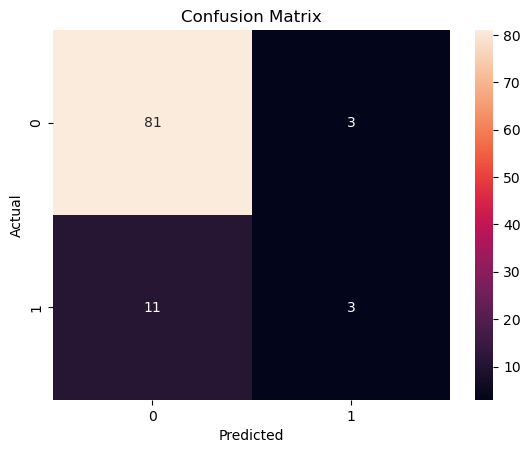

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have predictions and true labels
y_true = y_test  # Replace with your actual true labels
y_pred = predictions  # Replace with your model's predictions

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


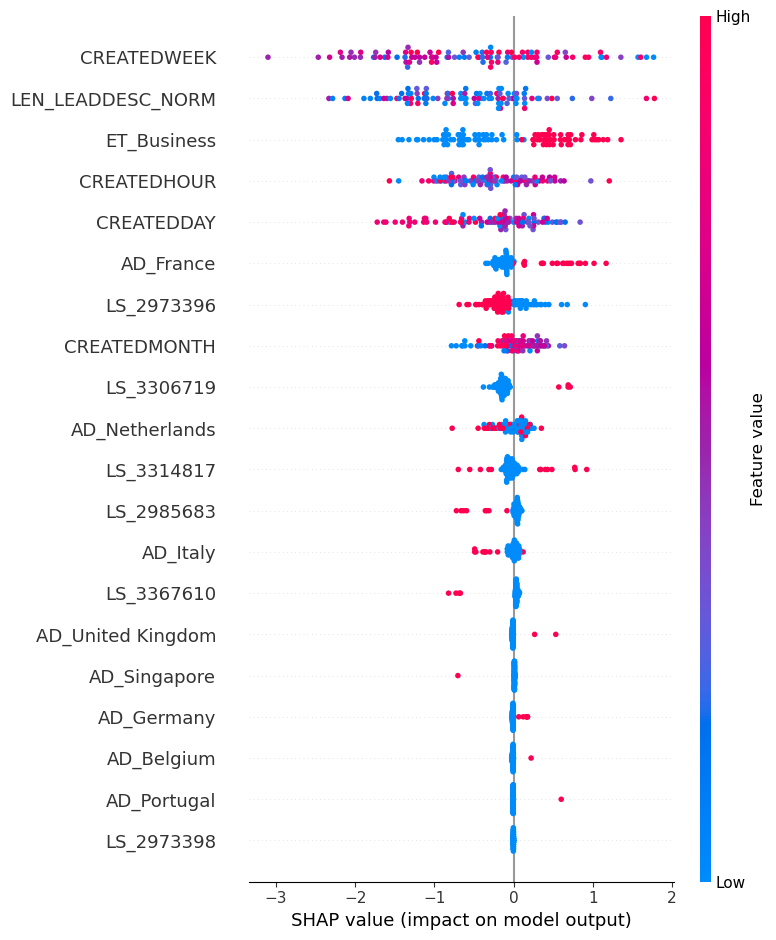

In [31]:
# Create a SHAP explainer object
explainer = shap.Explainer(xgb_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(leads_df_snowflake_test[feature_columns])

# Summarize the effects of all the features
shap.summary_plot(shap_values, leads_df_snowflake_test[feature_columns])


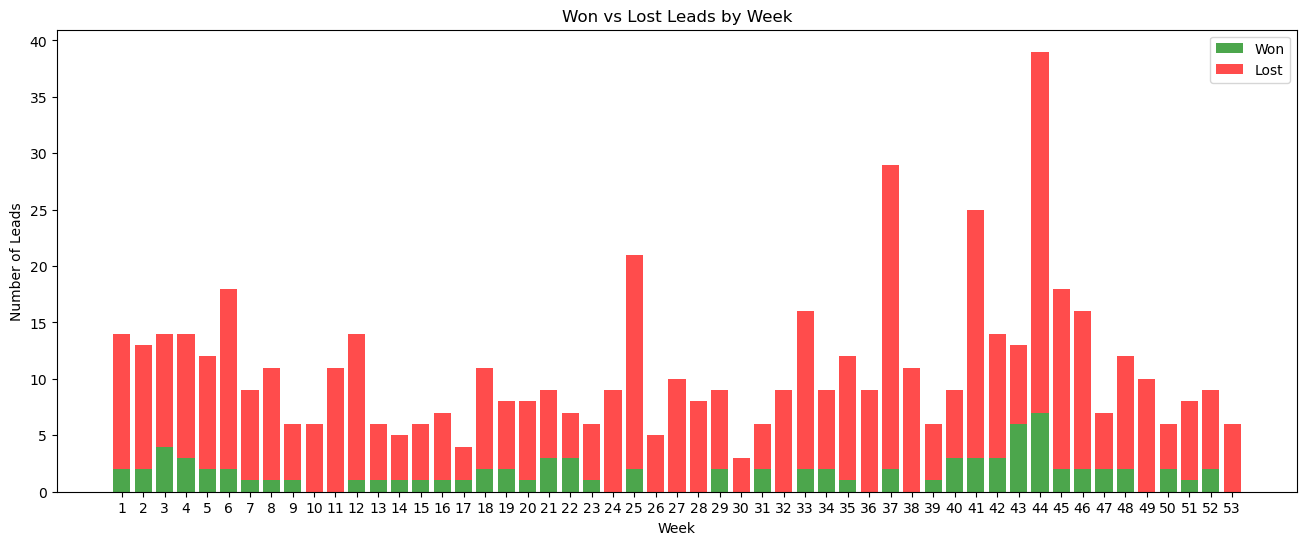

In [32]:
# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDWEEK'

# Calculate the count of won and lost leads for each week
week_counts_won = won_leads['CREATEDWEEK'].value_counts().sort_index()
week_counts_lost = lost_leads['CREATEDWEEK'].value_counts().sort_index()

# Ensure both series have the same weeks (in case some weeks are missing in either DataFrame)
all_weeks = week_counts_won.index.union(week_counts_lost.index)
week_counts_won = week_counts_won.reindex(all_weeks, fill_value=0)
week_counts_lost = week_counts_lost.reindex(all_weeks, fill_value=0)

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_weeks))
# Plotting the histogram
plt.figure(figsize=(16, 6))

# Plot the 'Won' category
plt.bar(x_pos, week_counts_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, week_counts_lost, bottom=week_counts_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Week')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Week')
plt.xticks(x_pos, all_weeks)
plt.legend()

# Show the plot
plt.show()



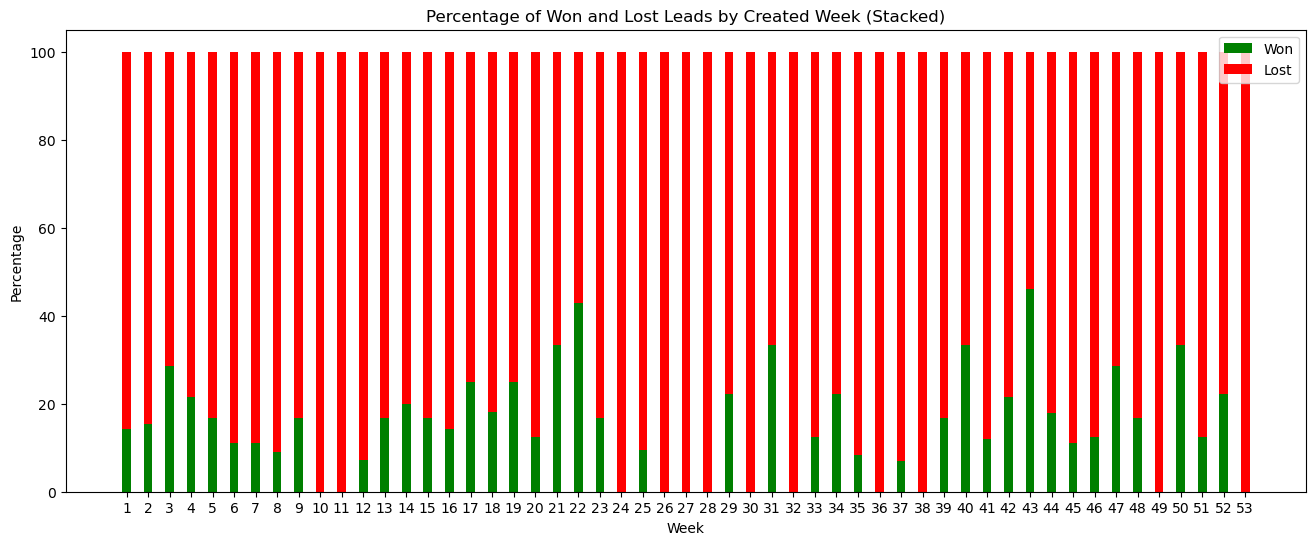

In [33]:
# Assuming 'won_leads' and 'lost_leads' are your datasets
# and 'CREATEDWEEK' is the feature you're interested in

# Define the bins for the histogram
bins = np.arange(1, 55, 1)  # for weeks, from 0 to 52

# Calculate histogram for Won and Lost leads
hist_won, _ = np.histogram(won_leads['CREATEDWEEK'], bins=bins)
hist_lost, _ = np.histogram(lost_leads['CREATEDWEEK'], bins=bins)

# Calculate the total leads for each bin
total_leads = hist_won + hist_lost

# Avoid division by zero
total_leads[total_leads == 0] = 1

# Calculate percentages
percent_won = (hist_won / total_leads) * 100
percent_lost = (hist_lost / total_leads) * 100

# Plotting
plt.figure(figsize=(16, 6))
plt.bar(bins[:-1], percent_won, width=0.4, label='Won', align='center', color='green')
plt.bar(bins[:-1], percent_lost, width=0.4, bottom=percent_won, label='Lost', align='center', color='red')
plt.xlabel('Week')
plt.ylabel('Percentage')
plt.title('Percentage of Won and Lost Leads by Created Week (Stacked)')
plt.legend()

# Set x-axis ticks to show every week
plt.xticks(bins[:-1])  # Set x-ticks to every week

plt.show()

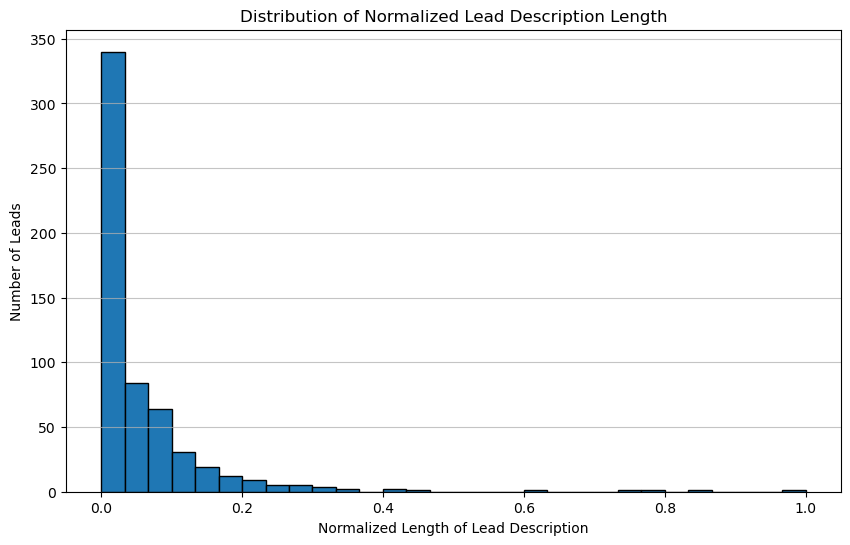

In [34]:
# Assuming your DataFrame is named 'leads_df' and the normalized length column is 'LEN_LEADDESC_NORM'
pd_leads_df = leads_df_snowflake.to_pandas()
len_norm_data = pd_leads_df['LEN_LEADDESC_NORM']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(len_norm_data, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Normalized Lead Description Length')
plt.xlabel('Normalized Length of Lead Description')
plt.ylabel('Number of Leads')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()


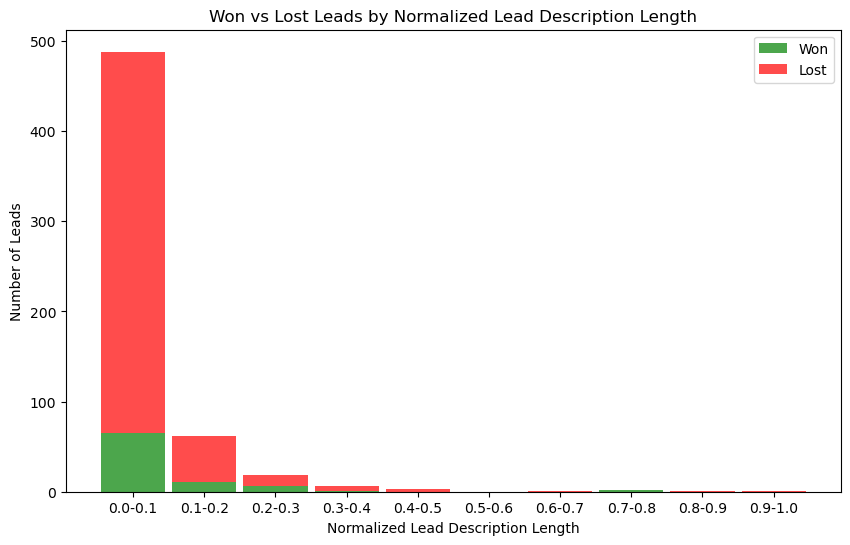

In [35]:
# Define the bin edges
bins = np.arange(0, 1.1, 0.1)  # Creates an array from 0 to 1 with a step of 0.1
# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Calculate the histogram data for won and lost leads
hist_won, _ = np.histogram(won_leads['LEN_LEADDESC_NORM'], bins=bins)
hist_lost, _ = np.histogram(lost_leads['LEN_LEADDESC_NORM'], bins=bins)

# Create an array for the positions of the bars on the x-axis
x_pos = (bins[:-1] + bins[1:]) / 2  # Midpoint of each bin

# Plotting the histogram
plt.figure(figsize=(10, 6))

# Plot the 'Won' category
plt.bar(x_pos, hist_won, width=0.09, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, hist_lost, width=0.09, bottom=hist_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Normalized Lead Description Length')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Normalized Lead Description Length')
plt.xticks(x_pos, labels=[f"{round(b, 1)}-{round(b+0.1, 1)}" for b in bins[:-1]])
plt.legend()

# Show the plot
plt.show()


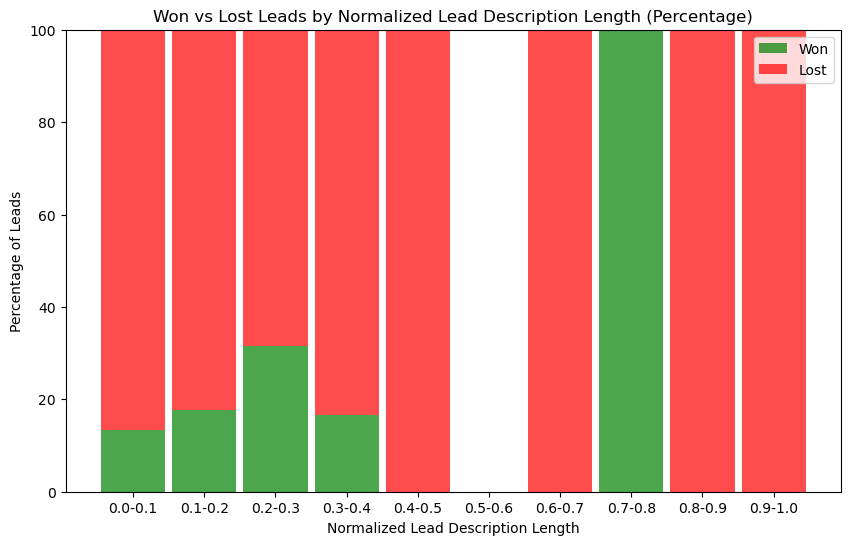

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bin edges
bins = np.arange(0, 1.1, 0.1)  # Creates an array from 0 to 1 with a step of 0.1

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Calculate the histogram data for won and lost leads
hist_won, _ = np.histogram(won_leads['LEN_LEADDESC_NORM'], bins=bins)
hist_lost, _ = np.histogram(lost_leads['LEN_LEADDESC_NORM'], bins=bins)

# Calculate the total leads for each bin
total_leads_per_bin = hist_won + hist_lost

# Calculate the percentage of won and lost leads for each bin
percentage_won = (hist_won / total_leads_per_bin) * 100
percentage_lost = (hist_lost / total_leads_per_bin) * 100

# Create an array for the positions of the bars on the x-axis
x_pos = (bins[:-1] + bins[1:]) / 2  # Midpoint of each bin

# Plotting the histogram
plt.figure(figsize=(10, 6))

# Plot the 'Won' category
plt.bar(x_pos, percentage_won, width=0.09, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, percentage_lost, width=0.09, bottom=percentage_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Normalized Lead Description Length')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Normalized Lead Description Length (Percentage)')
plt.xticks(x_pos, labels=[f"{round(b, 1)}-{round(b+0.1, 1)}" for b in bins[:-1]])
plt.legend()

# Show the plot
plt.show()

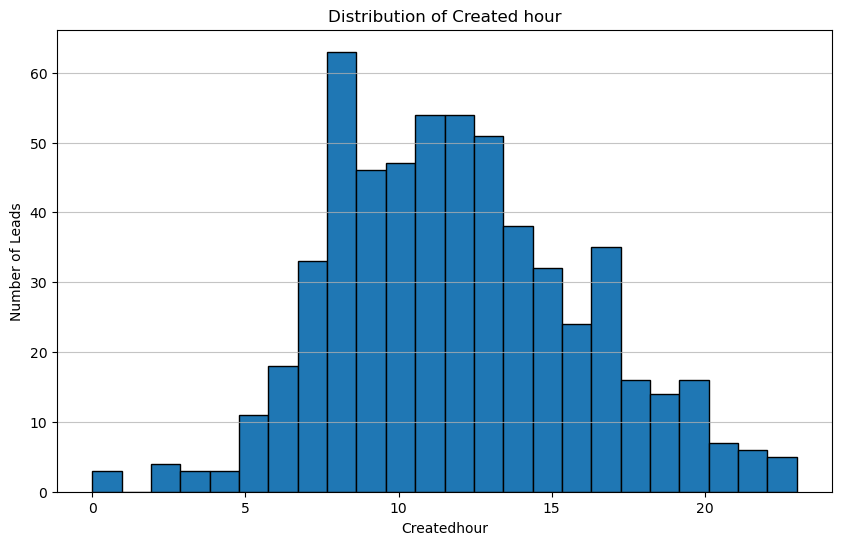

In [37]:
# Assuming your DataFrame is named 'leads_df' and the normalized length column is 'LEN_LEADDESC_NORM'
pd_leads_df = leads_df_snowflake.to_pandas()
len_norm_data = pd_leads_df['CREATEDHOUR']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(len_norm_data, bins=24, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Created hour')
plt.xlabel('Createdhour')
plt.ylabel('Number of Leads')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

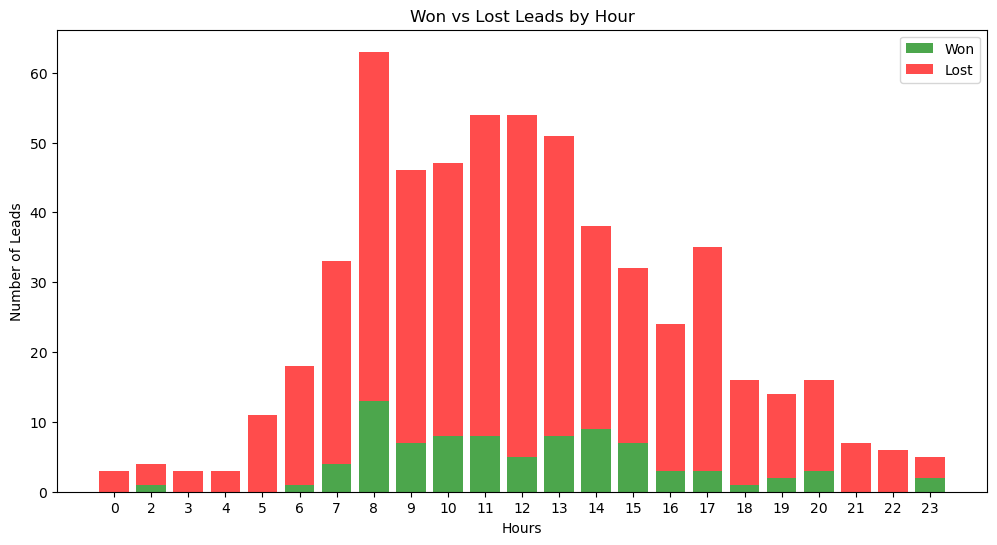

In [38]:
# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDHOUR'

# Calculate the count of won and lost leads for each week
hours_counts_won = won_leads['CREATEDHOUR'].value_counts().sort_index()
hours_counts_lost = lost_leads['CREATEDHOUR'].value_counts().sort_index()

# Ensure both series have the same weeks (in case some weeks are missing in either DataFrame)
all_hours = hours_counts_won.index.union(hours_counts_lost.index)
hours_counts_won = hours_counts_won.reindex(all_hours, fill_value=0)
hours_counts_lost = hours_counts_lost.reindex(all_hours, fill_value=0)

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_hours))
# Plotting the histogram
plt.figure(figsize=(12, 6))

# Plot the 'Won' category
plt.bar(x_pos, hours_counts_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, hours_counts_lost, bottom=hours_counts_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Hours')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Hour')
plt.xticks(x_pos, all_hours)
plt.legend()

# Show the plot
plt.show()

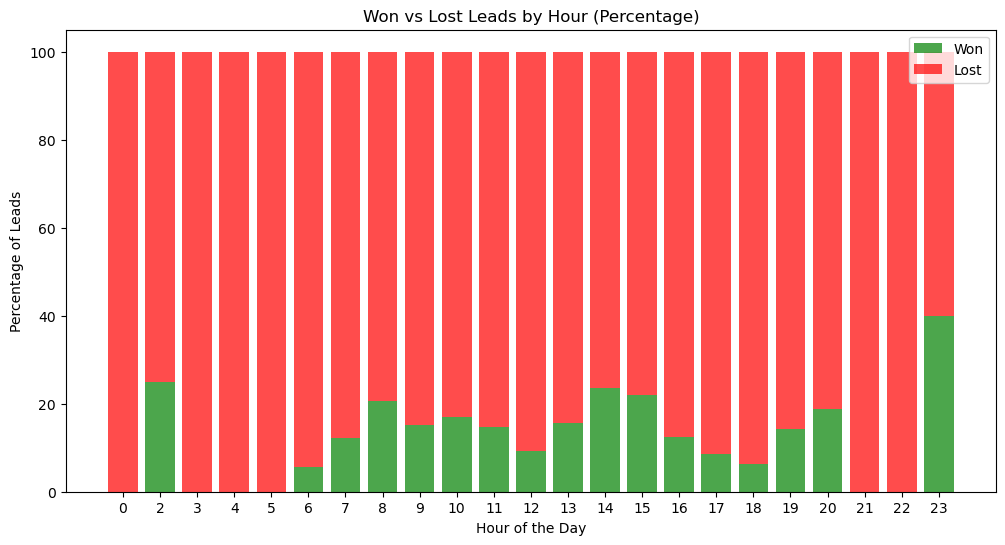

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Calculate the count of won and lost leads for each hour
hours_counts_won = won_leads['CREATEDHOUR'].value_counts().sort_index()
hours_counts_lost = lost_leads['CREATEDHOUR'].value_counts().sort_index()

# Ensure both series have the same hours (in case some hours are missing in either DataFrame)
all_hours = hours_counts_won.index.union(hours_counts_lost.index)
hours_counts_won = hours_counts_won.reindex(all_hours, fill_value=0)
hours_counts_lost = hours_counts_lost.reindex(all_hours, fill_value=0)

# Calculate the total leads for each hour
total_leads_per_hour = hours_counts_won + hours_counts_lost

# Calculate the percentage of won and lost leads for each hour
percentage_won = (hours_counts_won / total_leads_per_hour) * 100
percentage_lost = (hours_counts_lost / total_leads_per_hour) * 100

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_hours))

# Plotting the histogram
plt.figure(figsize=(12, 6))

# Plot the 'Won' category
plt.bar(x_pos, percentage_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, percentage_lost, align='center', alpha=0.7, color='red', bottom=percentage_won, label='Lost')

# Add labels, title, and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Hour (Percentage)')
plt.xticks(x_pos, all_hours)
plt.legend()

# Show the plot
plt.show()


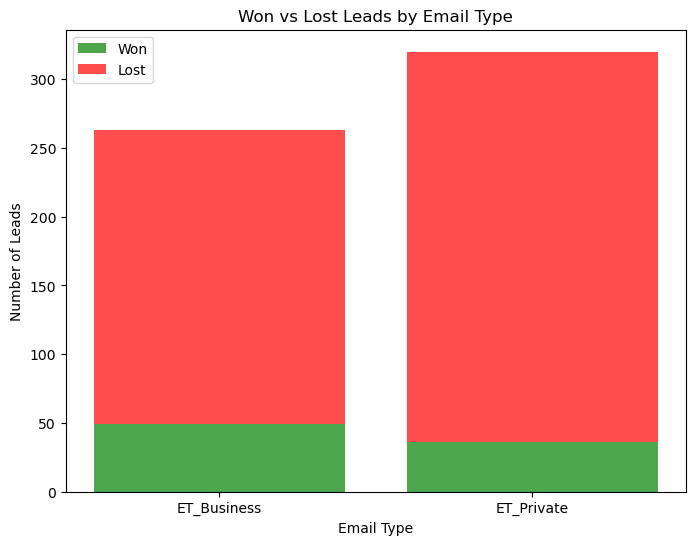

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Calculate the count of won and lost leads for each email type
won_business = won_leads[won_leads['ET_Business'] == 1].shape[0]
lost_business = lost_leads[lost_leads['ET_Business'] == 1].shape[0]

won_private = won_leads[won_leads['ET_Private'] == 1].shape[0]
lost_private = lost_leads[lost_leads['ET_Private'] == 1].shape[0]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(2)

# Plotting the histogram
plt.figure(figsize=(8, 6))

# Plot the 'Won' category for Business and Private
plt.bar(x_pos, [won_business, won_private], align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won' for Business and Private
plt.bar(x_pos, [lost_business, lost_private], bottom=[won_business, won_private], align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Email Type')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Email Type')
plt.xticks(x_pos, ['ET_Business', 'ET_Private'])
plt.legend()

# Show the plot
plt.show()


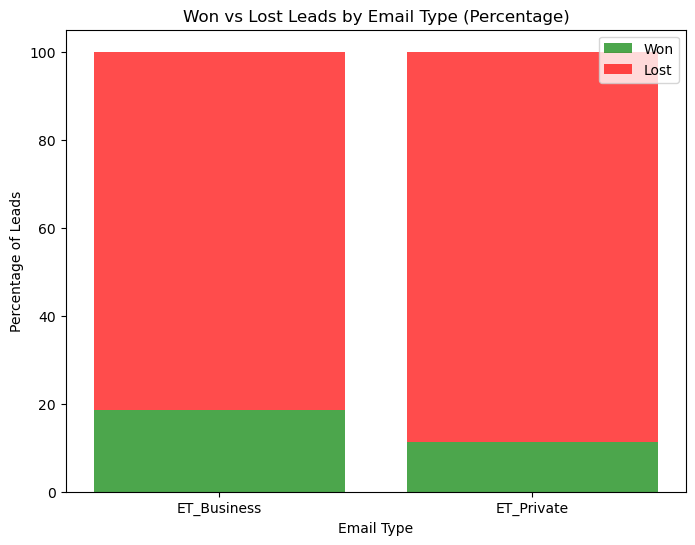

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Calculate the count of won and lost leads for each email type
won_business = won_leads[won_leads['ET_Business'] == 1].shape[0]
lost_business = lost_leads[lost_leads['ET_Business'] == 1].shape[0]

won_private = won_leads[won_leads['ET_Private'] == 1].shape[0]
lost_private = lost_leads[lost_leads['ET_Private'] == 1].shape[0]

# Calculate the total leads for each email type
total_business = won_business + lost_business
total_private = won_private + lost_private

# Calculate the percentages
percent_won_business = (won_business / total_business) * 100 if total_business > 0 else 0
percent_lost_business = (lost_business / total_business) * 100 if total_business > 0 else 0

percent_won_private = (won_private / total_private) * 100 if total_private > 0 else 0
percent_lost_private = (lost_private / total_private) * 100 if total_private > 0 else 0

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(2)

# Plotting the histogram
plt.figure(figsize=(8, 6))

# Plot the 'Won' percentage for Business and Private
plt.bar(x_pos, [percent_won_business, percent_won_private], align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for Business and Private
plt.bar(x_pos, [percent_lost_business, percent_lost_private], bottom=[percent_won_business, percent_won_private], align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Email Type')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Email Type (Percentage)')
plt.xticks(x_pos, ['ET_Business', 'ET_Private'])
plt.legend()

# Show the plot
plt.show()


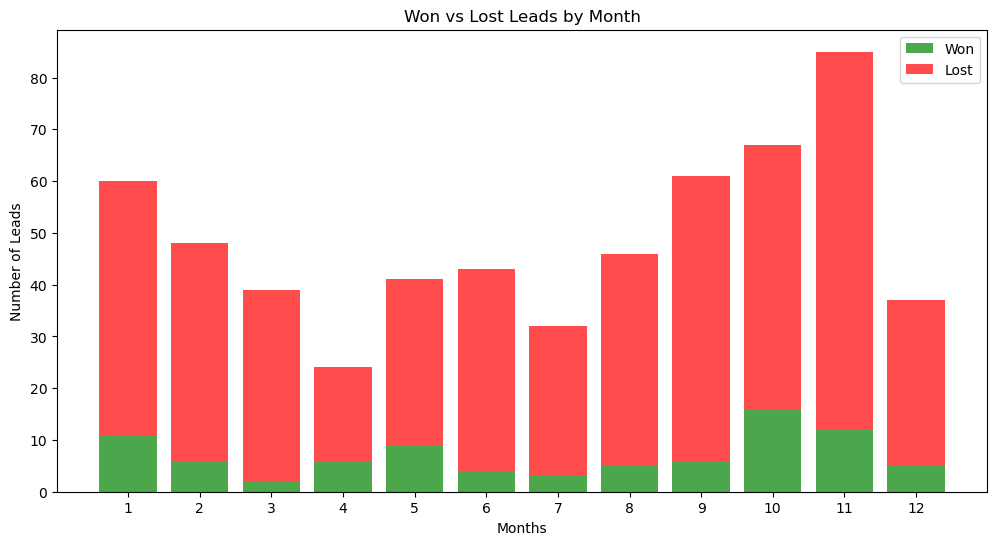

In [42]:
# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDHOUR'

# Calculate the count of won and lost leads for each week
months_counts_won = won_leads['CREATEDMONTH'].value_counts().sort_index()
months_counts_lost = lost_leads['CREATEDMONTH'].value_counts().sort_index()

# Ensure both series have the same weeks (in case some weeks are missing in either DataFrame)
all_months = months_counts_won.index.union(months_counts_lost.index)
months_counts_won = months_counts_won.reindex(all_months, fill_value=0)
months_counts_lost = months_counts_lost.reindex(all_months, fill_value=0)

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_months))
# Plotting the histogram
plt.figure(figsize=(12, 6))

# Plot the 'Won' category
plt.bar(x_pos, months_counts_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, months_counts_lost, bottom=months_counts_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Months')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Month')
plt.xticks(x_pos, all_months)
plt.legend()

# Show the plot
plt.show()

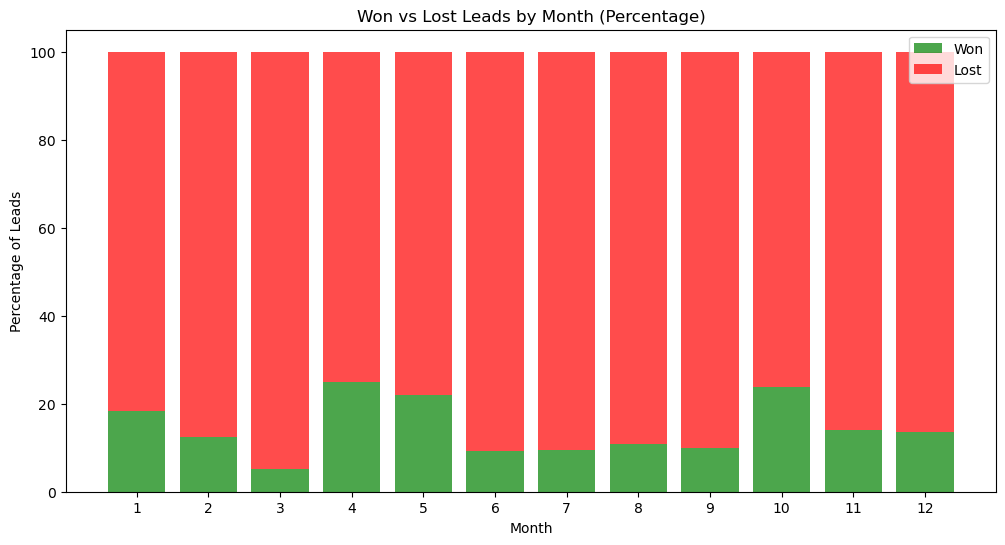

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Calculate the count of won and lost leads for each month
months_counts_won = won_leads['CREATEDMONTH'].value_counts().sort_index()
months_counts_lost = lost_leads['CREATEDMONTH'].value_counts().sort_index()

# Ensure both series have the same months
all_months = months_counts_won.index.union(months_counts_lost.index)
months_counts_won = months_counts_won.reindex(all_months, fill_value=0)
months_counts_lost = months_counts_lost.reindex(all_months, fill_value=0)

# Calculate the total leads for each month
total_leads_per_month = months_counts_won + months_counts_lost

# Calculate the percentages
percent_won = (months_counts_won / total_leads_per_month) * 100
percent_lost = (months_counts_lost / total_leads_per_month) * 100

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_months))

# Plotting the histogram
plt.figure(figsize=(12, 6))

# Plot the 'Won' percentage for each month
plt.bar(x_pos, percent_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for each month
plt.bar(x_pos, percent_lost, bottom=percent_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Month (Percentage)')
plt.xticks(x_pos, all_months)
plt.legend()

# Show the plot
plt.show()


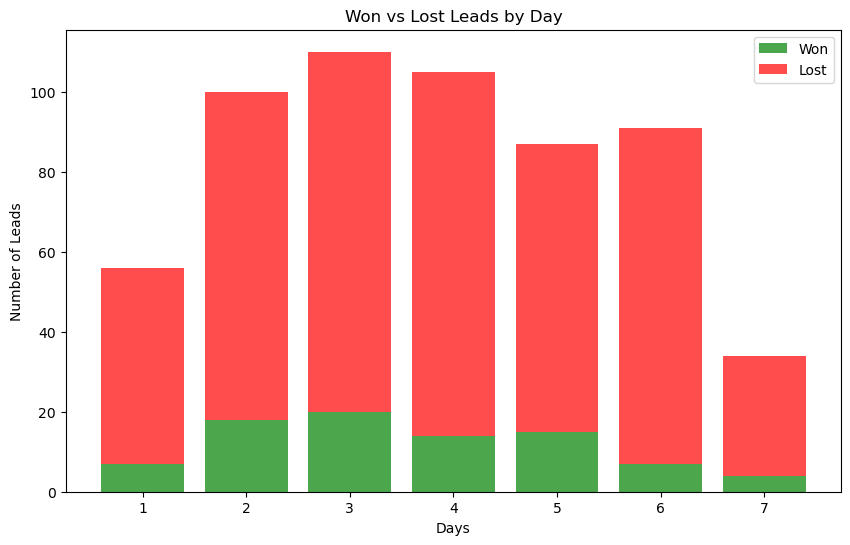

In [44]:
# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDHOUR'

# Calculate the count of won and lost leads for each week
days_counts_won = won_leads['CREATEDDAY'].value_counts().sort_index()
days_counts_lost = lost_leads['CREATEDDAY'].value_counts().sort_index()

# Ensure both series have the same weeks (in case some weeks are missing in either DataFrame)
all_days = days_counts_won.index.union(days_counts_lost.index)
days_counts_won = days_counts_won.reindex(all_days, fill_value=0)
days_counts_lost = days_counts_lost.reindex(all_days, fill_value=0)

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_days))
# Plotting the histogram
plt.figure(figsize=(10, 6))

# Plot the 'Won' category
plt.bar(x_pos, days_counts_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, days_counts_lost, bottom=days_counts_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Days')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Day')
plt.xticks(x_pos, all_days)
plt.legend()

# Show the plot
plt.show()

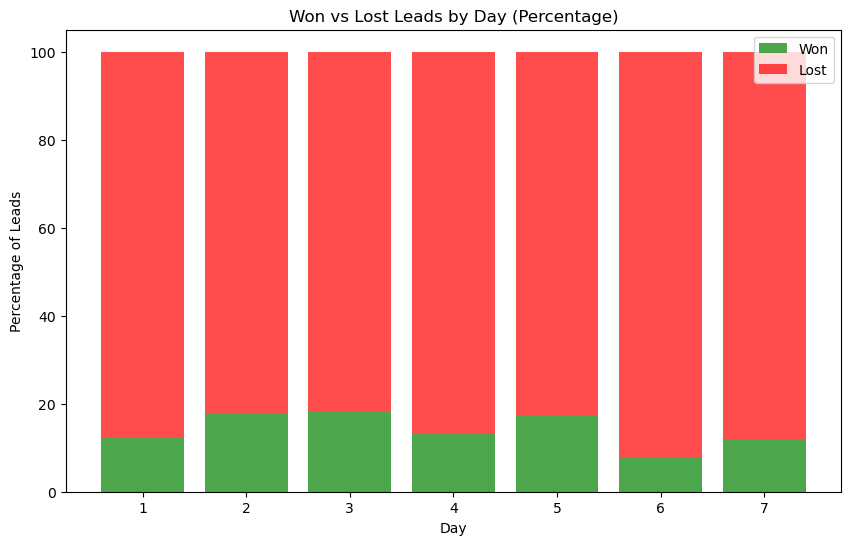

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDDAY'

# Calculate the count of won and lost leads for each day
days_counts_won = won_leads['CREATEDDAY'].value_counts().sort_index()
days_counts_lost = lost_leads['CREATEDDAY'].value_counts().sort_index()

# Ensure both series have the same days
all_days = days_counts_won.index.union(days_counts_lost.index)
days_counts_won = days_counts_won.reindex(all_days, fill_value=0)
days_counts_lost = days_counts_lost.reindex(all_days, fill_value=0)

# Calculate the total leads for each day
total_leads_per_day = days_counts_won + days_counts_lost

# Calculate the percentage of won and lost leads for each day
percentage_won = (days_counts_won / total_leads_per_day) * 100
percentage_lost = (days_counts_lost / total_leads_per_day) * 100

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_days))

# Plotting the histogram
plt.figure(figsize=(10, 6))

# Plot the 'Won' category
plt.bar(x_pos, percentage_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, percentage_lost, bottom=percentage_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Day')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Day (Percentage)')
plt.xticks(x_pos, all_days)
plt.legend()

# Show the plot
plt.show()


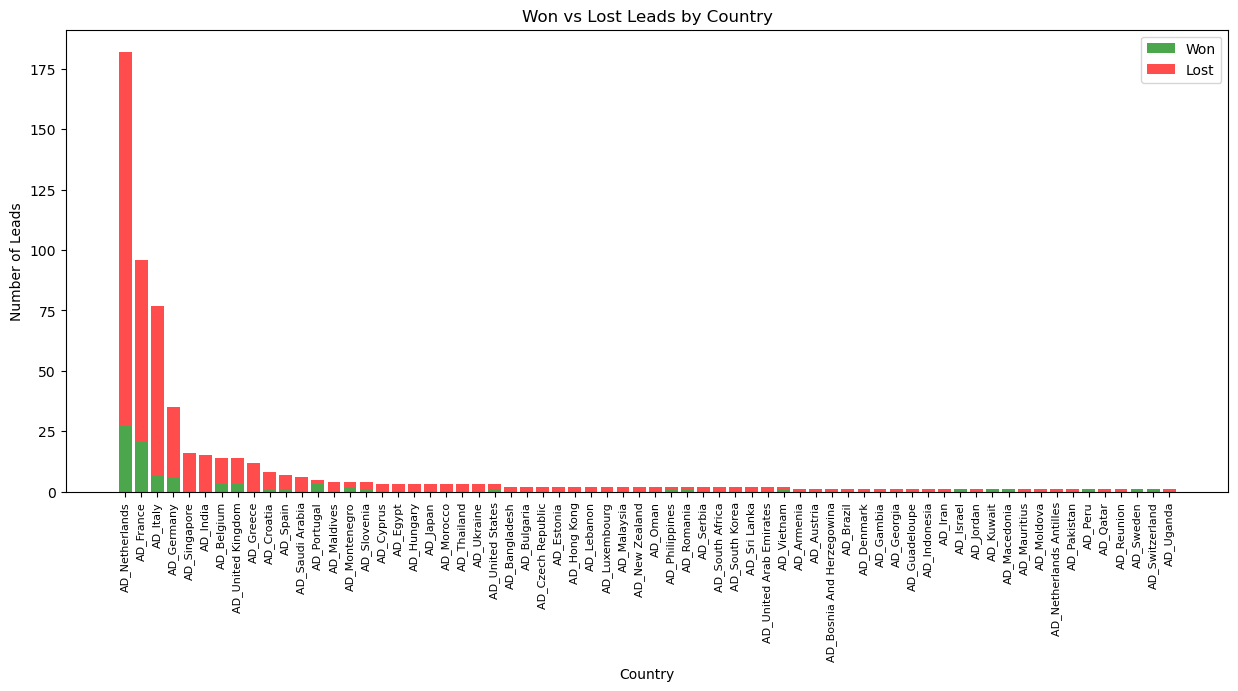

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Retrieve the columns containing the country values
country_columns = [col for col in leads_df_snowflake.columns if col.startswith(('"AD_'))]
country_columns = [col.replace('"', '') for col in country_columns]

# Initialize dictionaries to store the counts
won_counts = {country: won_leads[country].sum() for country in country_columns}
lost_counts = {country: lost_leads[country].sum() for country in country_columns}

# Calculate total leads per country and sort countries by total leads in descending order
total_leads = {country: won_counts[country] + lost_counts[country] for country in country_columns}
sorted_countries = sorted(total_leads, key=total_leads.get, reverse=True)

# Update the counts based on the sorted order
won_values = [won_counts[country] for country in sorted_countries]
lost_values = [lost_counts[country] for country in sorted_countries]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_countries))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' category for each country
plt.bar(x_pos, won_values, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won' for each country
plt.bar(x_pos, lost_values, bottom=won_values, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Country')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Country')
plt.xticks(x_pos, sorted_countries, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


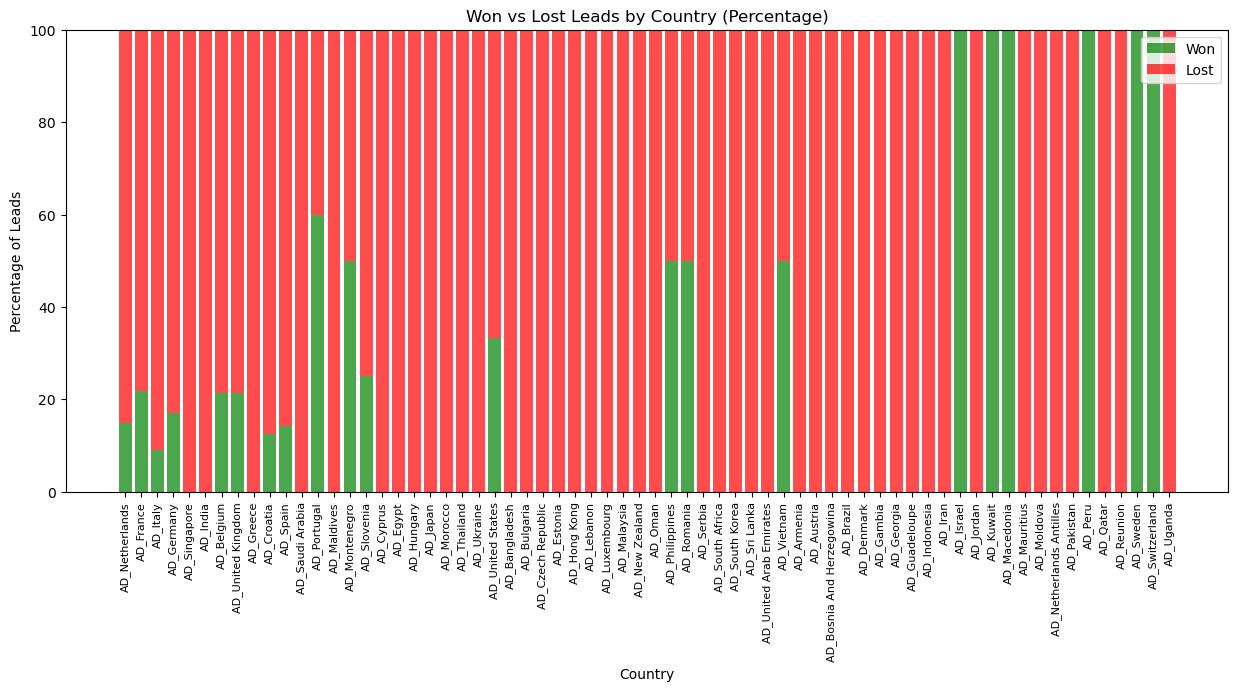

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Retrieve the columns containing the country values
country_columns = [col for col in leads_df_snowflake.columns if col.startswith(('"AD_'))]
country_columns = [col.replace('"', '') for col in country_columns]

# Initialize dictionaries to store the counts
won_counts = {country: won_leads[country].sum() for country in country_columns}
lost_counts = {country: lost_leads[country].sum() for country in country_columns}

# Calculate total leads per country and sort countries by total leads in descending order
total_leads = {country: won_counts[country] + lost_counts[country] for country in country_columns}
sorted_countries = sorted(total_leads, key=total_leads.get, reverse=True)

# Calculate the percentage of won and lost leads for each country
won_percentages = [won_counts[country] / total_leads[country] * 100 if total_leads[country] > 0 else 0 for country in sorted_countries]
lost_percentages = [lost_counts[country] / total_leads[country] * 100 if total_leads[country] > 0 else 0 for country in sorted_countries]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_countries))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' percentage for each country
plt.bar(x_pos, won_percentages, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for each country
plt.bar(x_pos, lost_percentages, bottom=won_percentages, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Country')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Country (Percentage)')
plt.xticks(x_pos, sorted_countries, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


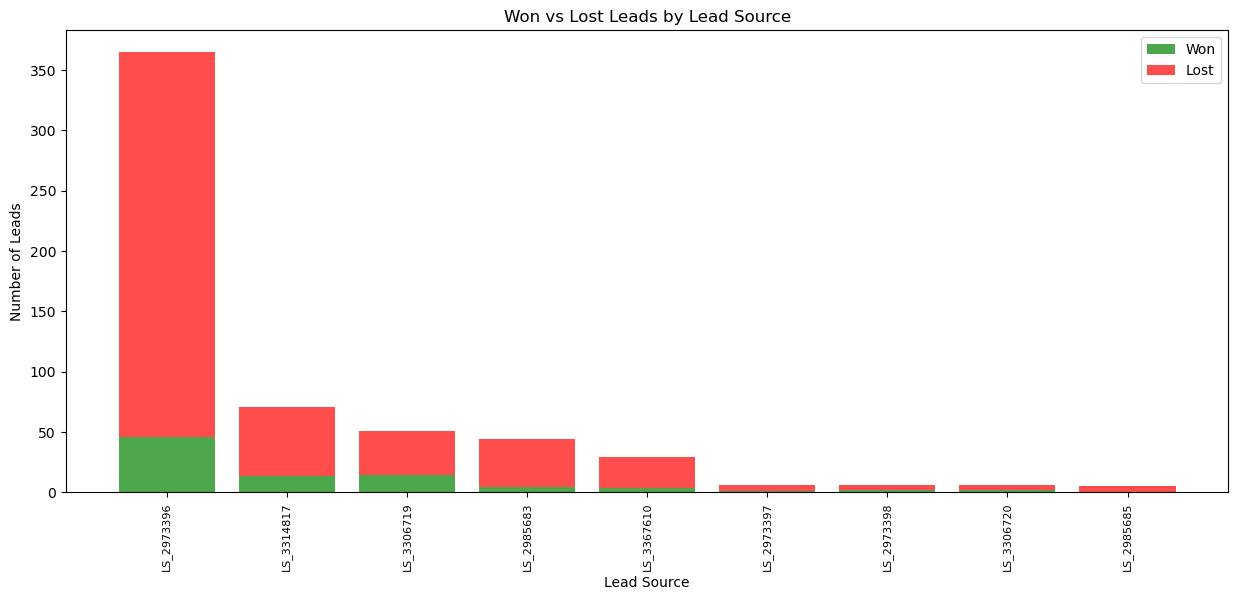

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Retrieve the columns containing the lead source values
leadsource_columns = [col for col in leads_df_snowflake.columns if col.startswith(('LS_'))]

# Initialize dictionaries to store the counts
won_counts = {leadsource: won_leads[leadsource].sum() for leadsource in leadsource_columns}
lost_counts = {leadsource: lost_leads[leadsource].sum() for leadsource in leadsource_columns}

# Calculate total leads per lead source and sort lead sources by total leads in descending order
total_leads = {leadsource: won_counts[leadsource] + lost_counts[leadsource] for leadsource in leadsource_columns}
sorted_lead_sources = sorted(total_leads, key=total_leads.get, reverse=True)

# Extract the counts for plotting
won_values = [won_counts[leadsource] for leadsource in sorted_lead_sources]
lost_values = [lost_counts[leadsource] for leadsource in sorted_lead_sources]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_lead_sources))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' category for each lead source
plt.bar(x_pos, won_values, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won' for each lead source
plt.bar(x_pos, lost_values, bottom=won_values, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Lead Source')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Lead Source')
plt.xticks(x_pos, sorted_lead_sources, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


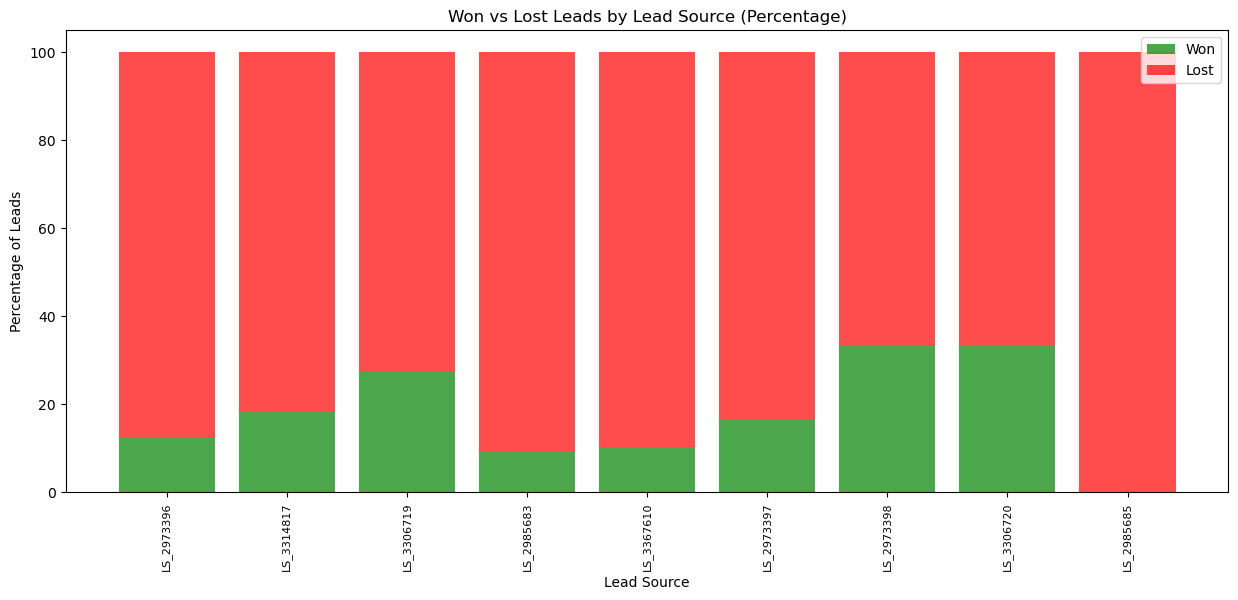

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Retrieve the columns containing the lead source values
leadsource_columns = [col for col in leads_df_snowflake.columns if col.startswith(('LS_'))]

# Initialize dictionaries to store the counts and percentages
won_counts = {leadsource: won_leads[leadsource].sum() for leadsource in leadsource_columns}
lost_counts = {leadsource: lost_leads[leadsource].sum() for leadsource in leadsource_columns}

# Calculate total leads per lead source and sort lead sources by total leads in descending order
total_leads = {leadsource: won_counts[leadsource] + lost_counts[leadsource] for leadsource in leadsource_columns}
sorted_lead_sources = sorted(total_leads, key=total_leads.get, reverse=True)

# Calculate the percentage of won and lost leads for each lead source
won_percentages = [won_counts[leadsource] / total_leads[leadsource] * 100 if total_leads[leadsource] > 0 else 0 for leadsource in sorted_lead_sources]
lost_percentages = [lost_counts[leadsource] / total_leads[leadsource] * 100 if total_leads[leadsource] > 0 else 0 for leadsource in sorted_lead_sources]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_lead_sources))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' percentage for each lead source
plt.bar(x_pos, won_percentages, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for each lead source
plt.bar(x_pos, lost_percentages, bottom=won_percentages, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Lead Source')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Lead Source (Percentage)')
plt.xticks(x_pos, sorted_lead_sources, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


In [50]:
# leadsource_columns
leadsource_columns = [col for col in leads_df_snowflake.columns 
                           if col.startswith(('LS_'))]
leadsource_df = leads_df_snowflake[leadsource_columns]
print(leadsource_columns)
leadsource_df.show()

['LS_2973396', 'LS_2973397', 'LS_2973398', 'LS_2985683', 'LS_2985685', 'LS_3306719', 'LS_3306720', 'LS_3314817', 'LS_3367610']
----------------------------------------------------------------------------------------------------------------------------------------
|"LS_2973396"  |"LS_2973397"  |"LS_2973398"  |"LS_2985683"  |"LS_2985685"  |"LS_3306719"  |"LS_3306720"  |"LS_3314817"  |"LS_3367610"  |
----------------------------------------------------------------------------------------------------------------------------------------
|1.0           |0.0           |0.0           |0.0           |0.0           |0.0           |0.0           |0.0           |0.0           |
|0.0           |0.0           |0.0           |1.0           |0.0           |0.0           |0.0           |0.0           |0.0           |
|0.0           |0.0           |0.0           |1.0           |0.0           |0.0           |0.0           |0.0           |0.0           |
|0.0           |0.0           |0.0           |1.0  

In [51]:
# country_columns
country_columns = [col for col in leads_df_snowflake.columns 
                           if col.startswith(('"AD_'))]
country_df = leads_df_snowflake[country_columns]
print(country_columns)
country_df.show()

['"AD_Armenia"', '"AD_Austria"', '"AD_Bangladesh"', '"AD_Belgium"', '"AD_Bosnia And Herzegowina"', '"AD_Brazil"', '"AD_Bulgaria"', '"AD_Croatia"', '"AD_Cyprus"', '"AD_Czech Republic"', '"AD_Denmark"', '"AD_Egypt"', '"AD_Estonia"', '"AD_France"', '"AD_Gambia"', '"AD_Georgia"', '"AD_Germany"', '"AD_Greece"', '"AD_Guadeloupe"', '"AD_Hong Kong"', '"AD_Hungary"', '"AD_India"', '"AD_Indonesia"', '"AD_Iran"', '"AD_Israel"', '"AD_Italy"', '"AD_Japan"', '"AD_Jordan"', '"AD_Kuwait"', '"AD_Lebanon"', '"AD_Luxembourg"', '"AD_Macedonia"', '"AD_Malaysia"', '"AD_Maldives"', '"AD_Mauritius"', '"AD_Moldova"', '"AD_Montenegro"', '"AD_Morocco"', '"AD_Netherlands"', '"AD_Netherlands Antilles"', '"AD_New Zealand"', '"AD_Oman"', '"AD_Pakistan"', '"AD_Peru"', '"AD_Philippines"', '"AD_Portugal"', '"AD_Qatar"', '"AD_Reunion"', '"AD_Romania"', '"AD_Saudi Arabia"', '"AD_Serbia"', '"AD_Singapore"', '"AD_Slovenia"', '"AD_South Africa"', '"AD_South Korea"', '"AD_Spain"', '"AD_Sri Lanka"', '"AD_Sweden"', '"AD_Switze

In [52]:
shap.initjs()

In [53]:
leads_df_snowflake_test_reordered = leads_df_snowflake_test[feature_columns]
instance_to_explain = leads_df_snowflake_test_reordered[feature_columns].iloc[26]
# Assuming instance_to_explain is a Pandas Series
instance_array = instance_to_explain.values.reshape(1, -1)
# Calculate SHAP values for this instance
shap_values_instance = explainer.shap_values(instance_array)
# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values_instance, instance_to_explain)
# shap.summary_plot(explainer.expected_value, shap_values_instance, instance_to_explain)

In [59]:
# Assuming xgb_classifier is your trained model and instance_to_explain is your data instance
# Reshape the instance data if necessary
instance_data = instance_to_explain.values.reshape(1, -1)

# Get the model's prediction for this instance
final_prediction = xgb_classifier.predict(instance_data)
print("Final Prediction for the instance:", final_prediction)


Final Prediction for the instance: [1]


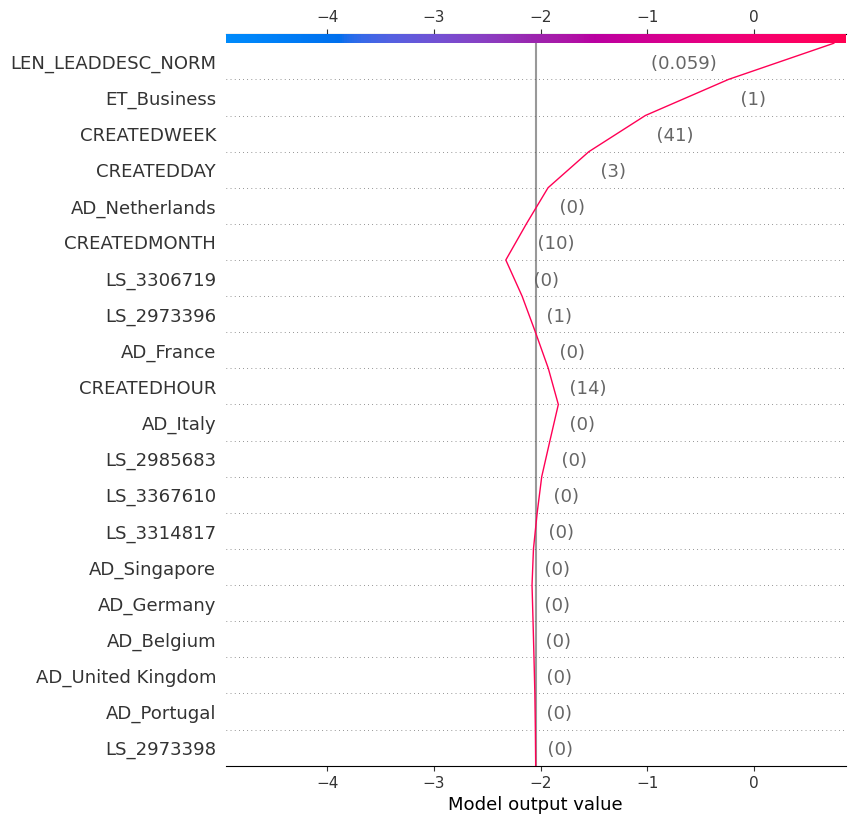

In [58]:
# Create the decision plot
shap.decision_plot(explainer.expected_value, shap_values[26], instance_to_explain)

In [54]:
print("Base value (expected value):", explainer.expected_value)

Base value (expected value): -2.0459294


In [55]:
# Convert the SHAP values for the instance into a DataFrame for easier interpretation
# shap_values_df = pd.DataFrame(shap_values_instance, columns=feature_columns)

# Display the DataFrame
# print(shap_values_df)


In [ ]:
probabilities = xgb_classifier.predict_proba(instance_data)
print("Probabilities for the instance:", probabilities)

In [ ]:
# Assuming 'xgb_classifier' is your trained XGBoost model
# and 'instance_to_explain' is the specific instance you want to explain

# Get the probability output for the instance
probabilities = xgb_classifier.predict_proba(instance_to_explain.values.reshape(1, -1))

# Print the probabilities
print(probabilities)
# print(instance_to_explain.to_csv())

In [ ]:
session.close()